In [1]:
import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel
from tqdm.notebook import tqdm

from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [60]:
class ClassifierModel():
    def __init__(self, model_name):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
    
        self.preprocess()
        
        self.model = self.set_model()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=4)
        
    
    def data_load(self):
        
        _dir = '../../data'
        
        trains = []
        vals = []
        tests = []
        
        datasets = [
            { 'name': 'preprocessed_train', 'frac': 1 },
            { 'name': 'train_rs', 'frac': 0.4 },
            { 'name': 'train_rd', 'frac': 0.35 }
        ]
        
        for it in datasets:
            _df = pd.read_csv(f'{_dir}/{it["name"]}.csv')
            
            _train = _df[:int(len(_df)*0.6)]
            _val = _df[int(len(_df)*0.6):int(len(_df)*0.8)]
            _test = _df[int(len(_df)*0.8):]
            
            if it["name"] == 'preprocessed_train':
                vals.append(_val)
                tests.append(_test)
            else:
                _train = _train.sample(frac=it['frac'])
                
            trains.append(_train)
            
        train = pd.concat(trains)
        train.drop_duplicates(inplace=True)
        val = pd.concat(vals)
        val.drop_duplicates(inplace=True)
        test = pd.concat(tests)
        test.drop_duplicates(inplace=True)
        
        return train, val, test
    
    
    def cls_embedding(self, data):
        for it in tqdm(data):
            inputs = self.tokenizer(it, return_tensors='tf', truncation=True)
            outputs = self.bert(inputs)
            cls_embeddings = outputs.last_hidden_state[:,0]
            yield cls_embeddings 
    
    
    def preprocess(self):
        
        train, val, test = self.data_load()
        
        train_cls_emb = list(self.cls_embedding(train['data']))
        self.x_train = pd.DataFrame(np.squeeze(np.array(train_cls_emb), axis=1))
        self.y_train = tf.keras.utils.to_categorical(train['label'], num_classes=4, dtype='float32')
        
        val_cls_emb = list(self.cls_embedding(val['data']))
        self.x_val = pd.DataFrame(np.squeeze(np.array(val_cls_emb), axis=1))
        self.y_val = tf.keras.utils.to_categorical(val['label'], num_classes=4, dtype='float32')
        
        test_cls_emb = list(self.cls_embedding(test['data']))
        self.x_test = pd.DataFrame(np.squeeze(np.array(test_cls_emb), axis=1))
        self.y_test = tf.keras.utils.to_categorical(test['label'], num_classes=4, dtype='float32')
        
    
    def set_model(self):
    
        inputs = Input(shape=(self.x_train.shape[1], 1))

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(inputs)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)
            
        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=100, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
                
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/100
65/65 [==============================] - 1s 9ms/step - loss: 1.4563 - accuracy: 0.2891 - val_loss: 1.3694 - val_accuracy: 0.3468
Epoch 2/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3738 - accuracy: 0.2958 - val_loss: 1.3638 - val_accuracy: 0.3835
Epoch 3/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3659 - accuracy: 0.3069 - val_loss: 1.3617 - val_accuracy: 0.3051
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3638 - accuracy: 0.3120 - val_loss: 1.3504 - val_accuracy: 0.3709
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3563 - accuracy: 0.3279 - val_loss: 1.3504 - val_accuracy: 0.3418
Epoch 6/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3499 - accuracy: 0.3349 - val_loss: 1.3321 - val_accuracy: 0.3734
Epoch 7/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3433 - accuracy: 0.3351 - val_loss: 1.3250 - val_accuracy: 0.3911
Epoch 8/100
6

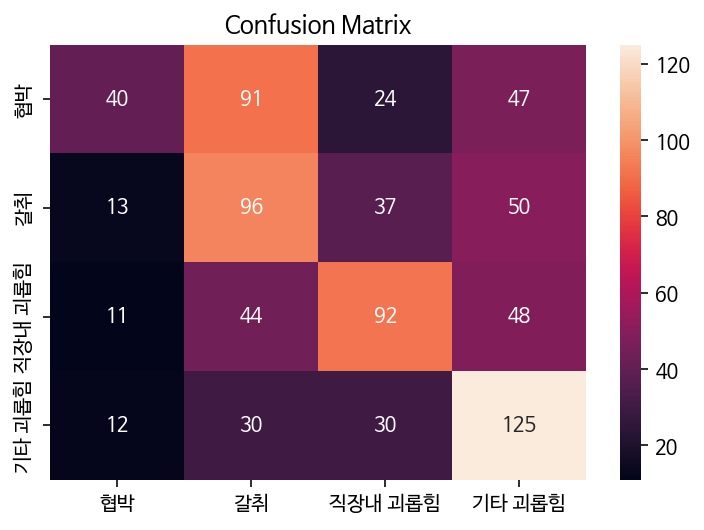

In [61]:
model = ClassifierModel('klue/bert-base')
model.train()
model.show_report()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/100
65/65 [==============================] - 1s 10ms/step - loss: 1.4053 - accuracy: 0.2623 - val_loss: 1.3775 - val_accuracy: 0.2949
Epoch 2/100
65/65 [==============================] - 0s 7ms/step - loss: 1.3781 - accuracy: 0.2847 - val_loss: 1.3761 - val_accuracy: 0.2924
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 1.3787 - accuracy: 0.2881 - val_loss: 1.3660 - val_accuracy: 0.3405
Epoch 4/100
65/65 [==============================] - 0s 7ms/step - loss: 1.3732 - accuracy: 0.2989 - val_loss: 1.3729 - val_accuracy: 0.3557
Epoch 5/100
65/65 [==============================] - 0s 7ms/step - loss: 1.3709 - accuracy: 0.2965 - val_loss: 1.3610 - val_accuracy: 0.3405
Epoch 6/100
65/65 [==============================] - 0s 7ms/step - loss: 1.3692 - accuracy: 0.3069 - val_loss: 1.3739 - val_accuracy: 0.2975
Epoch 7/100
65/65 [==============================] - 0s 7ms/step - loss: 1.3657 - accuracy: 0.3156 - val_loss: 1.3591 - val_accuracy: 0.3456
Epoch 8/100


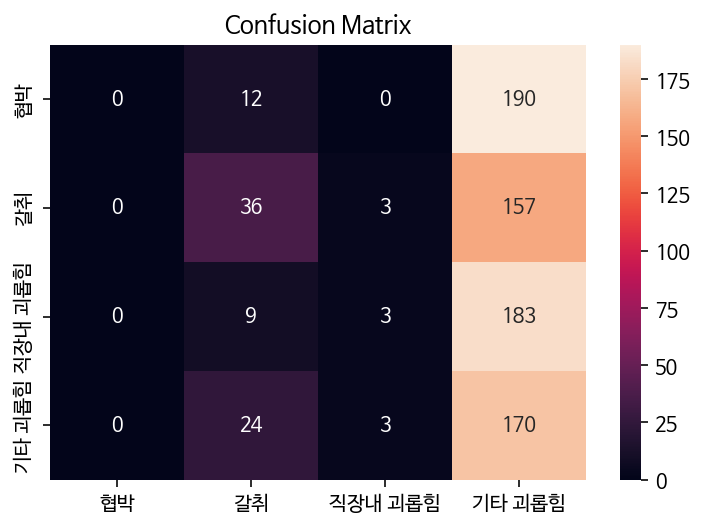

In [62]:
model = ClassifierModel('beomi/kcbert-base')
model.train()
model.show_report()